**Thư viện**

In [1]:
from sklearn.datasets import fetch_lfw_pairs
from sklearn.datasets import fetch_lfw_people
import matplotlib.pyplot as plt
import numpy as np
import random
import tensorflow as tf
from tensorflow.keras import layers, metrics
from tensorflow.keras.applications import ResNet152, Xception
import numpy as np
from tensorflow.keras import layers, models
from keras.regularizers import l2
from scipy import spatial
import cv2
from google.colab.patches import cv2_imshow
tf.random.set_seed(42)

**Hàm**

In [2]:
def visualize(image0, image1, proba=None):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1], axis=1), cmap='gray')
    if proba is not None:
        plt.suptitle("Distance: {:.2f}".format(proba))
    plt.show()


def triplet_data_generator(X, y, image_shape, max_size=None):
    total_size = max_size if max_size is not None else max(y)
    triplets = np.zeros((3, total_size, image_shape[0], image_shape[1], 3))
    idx_to_delete = []

    for i in range(total_size):
        idx = i
        anchor_image = X[idx]
        anchor_label = y[idx]

        same_person = np.where(y == anchor_label)[0]
        if len(same_person) > 1:
            idx_i = np.isin(same_person, idx)
            same_person = np.delete(same_person, idx_i)
            positive_index = np.random.choice(same_person)
            negative_index = np.random.choice(np.where(y != anchor_label)[0])
            positive_image = X[positive_index]
            negative_image = X[negative_index]
            # visualize(anchor_image, positive_image)
            # visualize(anchor_image, negative_image)
            triplets[0][i] = anchor_image
            triplets[1][i] = positive_image
            triplets[2][i] = negative_image
        else:
            idx_to_delete.append(i)
        # print("{percentage:.2f}%".format(percentage = (i * 100) / max(y)))

    triplets = np.delete(triplets, idx_to_delete, axis=1) # Remove people that doesn't have other photos of themself

    tmp = np.array([triplets[0,:], triplets[1,:], triplets[2,:]])
    tmp = np.transpose(tmp, (1, 0, 2, 3, 4))
    return tmp

def get_batch(train_triplet, batch_size):
    num_batches = len(train_triplet) // batch_size

    for i in range(num_batches):
        batch = train_triplet[i * batch_size : (i + 1) * batch_size]
        anchor_imgs = batch[:, 0]
        positive_imgs = batch[:, 1]
        negative_imgs = batch[:, 2]
        targets = np.zeros(batch_size) # or generate the appropriate targets
        yield [anchor_imgs, positive_imgs, negative_imgs], targets

In [3]:
class DistanceLayer(layers.Layer):
    # A layer to compute ‖f(A) - f(P)‖² and ‖f(A) - f(N)‖²
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(tf.abs(anchor - positive)), -1)
        an_distance = tf.reduce_sum(tf.square(tf.abs(anchor - negative)), -1)
        return (ap_distance, an_distance)

class SiameseNetwork():

    def __init__(self,
                 IMG_SHAPE,
                 cnn_filters=[64,64,128],
                 epochs=15,
                 lr=1e-4,
                 batch_size=32,
                 fine_tunning=False,
                 dropout_rate=0.3,
                 embedding_dim=64) -> None:
        self.IMG_SHAPE = IMG_SHAPE
        self.cnn_filters = cnn_filters
        self.epochs = epochs
        self.lr = lr
        self.batch_size = batch_size
        self.fine_tunning = fine_tunning
        self.dropout_rate = dropout_rate
        self.embedding_dim = embedding_dim
        self.model = None

    def get_embeddings(self):
        if self.fine_tunning is False:
            embedding_model = self._get_embeddings_from_scratch()
        else:
            embedding_model = self._get_fine_tunning_embeddings()
        return embedding_model

    def get_siamese_distance_siamese_network(self):
        anchor_input = layers.Input(shape=self.IMG_SHAPE, name='anchor_input')
        positive_input = layers.Input(shape=self.IMG_SHAPE, name='positive_input')
        negative_input = layers.Input(shape=self.IMG_SHAPE, name='negative_input')

        embedding_model = self.get_embeddings()

        # Generate the embeddings for the anchor, positive, and negative inputs
        anchor_embeddings = embedding_model(anchor_input)
        positive_embeddings = embedding_model(positive_input)
        negative_embeddings = embedding_model(negative_input)

        distances = DistanceLayer()(anchor_embeddings, positive_embeddings, negative_embeddings)

        self.model = models.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances, name="Embedding")
        return self.model

    def train(self, generator):
        steps_per_epoch = self.batch_size
        history = self.model.fit(generator, steps_per_epoch=steps_per_epoch, batch_size=self.batch_size, epochs=self.epochs)
        return history

    def get_test_model(self, embedding_layer=None):
        if embedding_layer is None:
            embedding_layer = self.model.layers[3]

        anchor_input = tf.keras.Input(shape=self.IMG_SHAPE)
        anchor_embeddings = embedding_layer(anchor_input)
        embedding_model = models.Model(inputs=anchor_input, outputs=anchor_embeddings)
        return embedding_model

    def test(self, X_test, y_test, embedding_layer=None):
        embedding_model = self.get_test_model(embedding_layer)

        embedding1 = embedding_model.predict(np.array(X_test[:, 0]))
        embedding2 = embedding_model.predict(np.array(X_test[:, 1]))

        similarities = []
        for i in range(len(embedding1)):
            similarity = 1 - spatial.distance.cosine(embedding1[i], embedding2[i])
            similarities.append(similarity)

        similarities = np.array(similarities)
        return similarities

    def _get_CNN(self):
        model = models.Sequential(name="CNN")
        model.add(layers.Rescaling(1./255),input_shape=self.IMG_SHAPE)
        for i in range(len(self.cnn_filters)):
            if i == 0:
                model.add(layers.Conv2D(self.cnn_filters[i], (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
            else:
                model.add(layers.Conv2D(self.cnn_filters[i], (3, 3), activation='relu', padding='same', kernel_regularizer=l2(1e-2)))
            model.add(layers.BatchNormalization())
            model.add(layers.MaxPooling2D())
            model.add(layers.Dropout(self.dropout_rate))

        model.add(layers.Flatten())
        model.add(layers.Dense(self.embedding_dim, activation=None))

        return model

    def _get_embeddings_from_scratch(self):
        return self._get_CNN()

    def _get_fine_tunning_embeddings(self):
        input = layers.Input(shape=self.IMG_SHAPE)
        # Xception
        pretrained_model = Xception(
            input_shape=self.IMG_SHAPE,
            weights='imagenet',
            include_top=False,
            pooling='avg',
        )

        for i in range(len(pretrained_model.layers)-27):
            pretrained_model.layers[i].trainable = False

        processed = pretrained_model(input)

        flatten = layers.Flatten()(processed)
        x = layers.Dense(512, activation='relu')(flatten)
        x = layers.BatchNormalization()(x)
        x = layers.Dense(self.embedding_dim, activation="relu")(x)
        embeddings = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(x)
        siamese_network = models.Model(inputs=input, outputs=embeddings, name="Embedding")
        return siamese_network


# From Kaggle class
class SiameseModel(models.Model):
    # Builds a Siamese model based on a base-model
    def __init__(self, siamese_network, margin=1.0):
        super(SiameseModel, self).__init__()

        self.margin = margin
        self.siamese_network = siamese_network
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(zip(gradients, self.siamese_network.trainable_weights))

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        ap_distance, an_distance = self.siamese_network(data)
        loss = tf.maximum(ap_distance - an_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

**CODE**

In [4]:
def visualize(image0, image1, image2):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1, image2], axis=1))
    plt.title("Anchor/Positive/Negative")
    plt.show()

def visualize_pair(image0, image1, similarity, label):
    # Plot the images
    plt.imshow(np.concatenate([image0, image1], axis=1))
    title = "Same person" if label == 1 else "Not same person"
    plt.title(title)
    if similarity is not None:
        plt.suptitle("Similarity: {:.2f}".format(similarity))

    plt.show()

def plot_training_loss(loss):
    plt.plot(loss, label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()

In [ ]:
lfw_train = fetch_lfw_people(resize=0.8, color=True)

X = lfw_train.images
y = lfw_train.target

IMG_SHAPE = (X.shape[1], X.shape[2], X.shape[3])
print(IMG_SHAPE)

(100, 75, 3)


In [ ]:
print(X.shape)

(13233, 100, 75, 3)


In [ ]:
train_data = triplet_data_generator(X, y, IMG_SHAPE, 500)

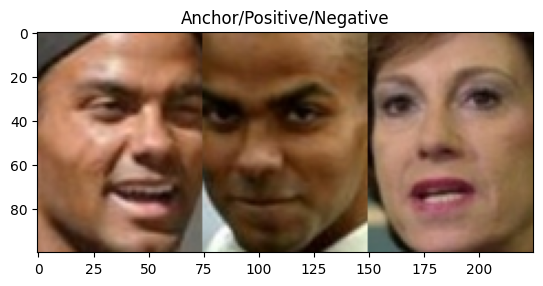

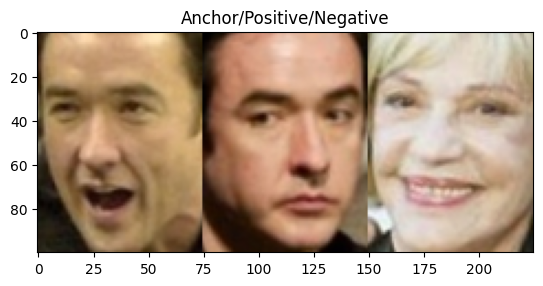

In [ ]:
visualize(train_data[3][0], train_data[3][1], train_data[3][2])
visualize(train_data[4][0], train_data[4][1], train_data[4][2])

83683744/83683744 [==============================] - 2s 0us/step


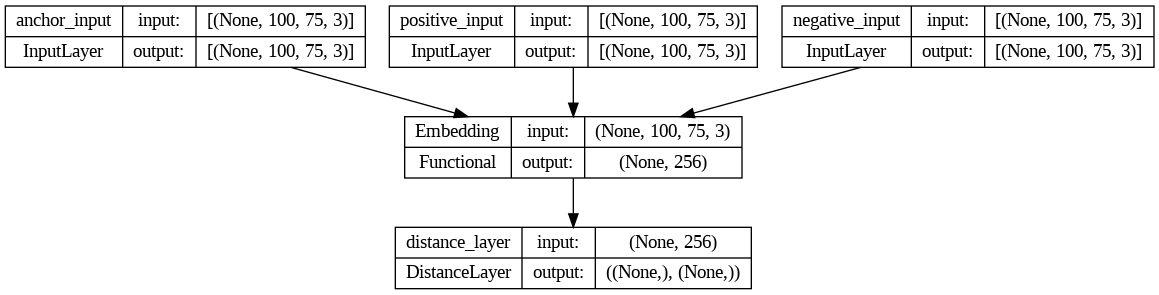

In [ ]:
batch_size = 128
epochs = 10
lr = 1e-3
triplet_loss_margin = 1
fine_tunning = True
embedding_dim = 256

## Unused
dropout_rate = 0.25
cnn_filters = [64, 64, 128]
##

# Embedding part
sn = SiameseNetwork(IMG_SHAPE, cnn_filters, epochs, lr, batch_size, fine_tunning, dropout_rate, embedding_dim)
distances_model = sn.get_siamese_distance_siamese_network()
embedding_layer = distances_model.layers[3]

# Siamese Part
siamese_model = SiameseModel(distances_model, margin=triplet_loss_margin)
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

tf.keras.utils.plot_model(distances_model, show_shapes=True, to_file="architecture.png", show_layer_names=True)

In [ ]:
distances_model.summary()

Model: "Embedding"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 100, 75, 3)]         0         []                            
                                                                                                  
 positive_input (InputLayer  [(None, 100, 75, 3)]         0         []                            
 )                                                                                                
                                                                                                  
 negative_input (InputLayer  [(None, 100, 75, 3)]         0         []                            
 )                                                                                                
                                                                                          

In [ ]:
loss_history = []

for i in range(epochs):

    print("=================")
    print("Epoch", i)
    epoch_loss = []
    for batch, _ in get_batch(train_data, batch_size):
        loss = siamese_model.train_on_batch(batch)
        epoch_loss.append(loss)
    epoch_loss = sum(epoch_loss)/len(epoch_loss)
    loss_history.append(epoch_loss)
    print("Loss: ", epoch_loss)
    print("=================\n")

Epoch 0
Loss:  0.8586893081665039

Epoch 1
Loss:  0.5905099809169769

Epoch 2
Loss:  0.5594975352287292

Epoch 3
Loss:  0.4440260976552963

Epoch 4
Loss:  0.28411296010017395

Epoch 5
Loss:  0.21909287571907043

Epoch 6
Loss:  0.16379399597644806

Epoch 7
Loss:  0.1273198537528515

Epoch 8
Loss:  0.09237073361873627

Epoch 9
Loss:  0.06885279715061188



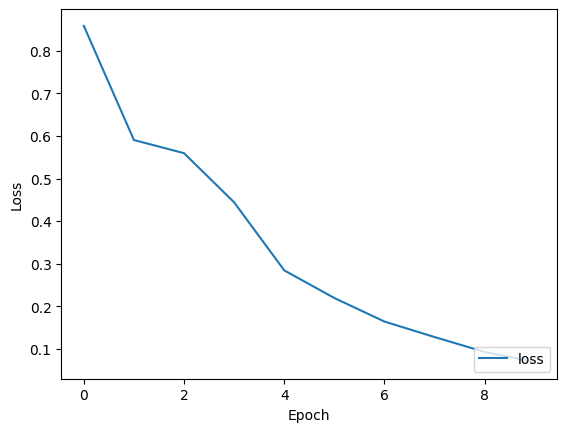

In [ ]:
plot_training_loss(loss_history)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.keras.models.save_model(embedding_layer, '/content/drive/MyDrive/MyFolder/embedding_layer.h5')

In [7]:
embedding_layer = tf.keras.models.load_model('/content/drive/MyDrive/MyFolder/embedding_layer.h5', compile=False)

In [8]:
lfw_pairs_test = fetch_lfw_pairs(subset="test", resize=0.8, color=True)
classes = list(lfw_pairs_test.target_names)
X_test = lfw_pairs_test.pairs
X_test = X_test.astype("float32")
IMG_SHAPE = (X_test[0].shape[1], X_test[0].shape[2], X_test[0].shape[3])
print(IMG_SHAPE)
y_test = lfw_pairs_test.target

(100, 75, 3)


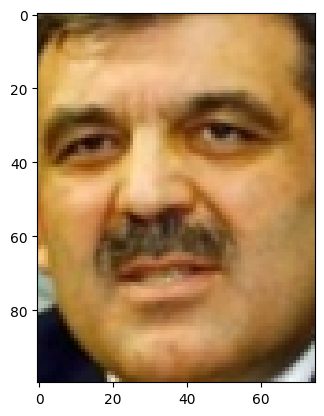

In [11]:
plt.imshow(X_test[0][0])

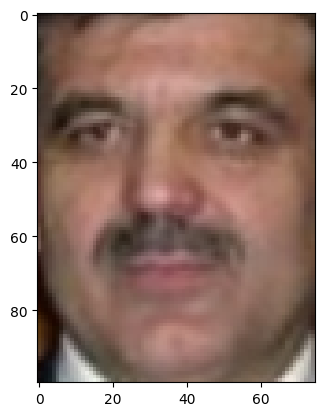

In [12]:
plt.imshow(X_test[0][1])

In [13]:
X_test.shape

(1000, 2, 100, 75, 3)

In [14]:
X_test[:, 0].shape

(1000, 100, 75, 3)

In [15]:
def get_test_model(embedding_layer, IMG_SHAPE):
    anchor_input = tf.keras.Input(shape=IMG_SHAPE)
    anchor_embeddings = embedding_layer(anchor_input)
    embedding_model = models.Model(inputs=anchor_input, outputs=anchor_embeddings)
    return embedding_model

def test(X_test, embedding_layer, IMG_SHAPE):
    embedding_model = get_test_model(embedding_layer, IMG_SHAPE)

    embedding1 = embedding_model.predict(np.array(X_test[:, 0]))
    embedding2 = embedding_model.predict(np.array(X_test[:, 1]))

    similarities = []
    for i in range(len(embedding1)):
        similarity = 1 - spatial.distance.cosine(embedding1[i], embedding2[i])
        similarities.append(similarity)

    similarities = np.array(similarities)
    return similarities

In [16]:
similarities = test(X_test, embedding_layer, IMG_SHAPE)
print(similarities.shape)

32/32 [==============================] - 30s 933ms/step
(1000,)


In [19]:
not_same_people_idxs = similarities[y_test == 0]
same_people_idxs = similarities[y_test == 1]

print("Number of different pair:", not_same_people_idxs.shape)
print("Number of same pair:", same_people_idxs.shape)

avg_for_not_same_people = np.mean(not_same_people_idxs)
avg_for_same_people = np.mean(same_people_idxs)

classes = list(lfw_pairs_test.target_names)
print(classes[0], "(similarity mean)", avg_for_not_same_people)
print(classes[1], "(similarity mean)", avg_for_same_people)

threshold = (avg_for_not_same_people + avg_for_same_people) / 2
print("Threshold:", threshold)

binary_classification = np.zeros_like(similarities)
binary_classification[similarities >= threshold] = 1

accuracy = np.mean(binary_classification == y_test)
print("Accuracy:", accuracy)

Number of different pair: (500,)
Number of same pair: (500,)
Different persons (similarity mean) 0.36146489607663534
Same person (similarity mean) 0.6831659476249479
Threshold: 0.5223154218507916
Accuracy: 0.729


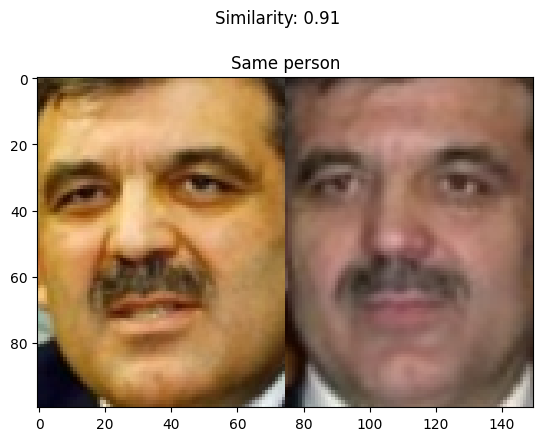

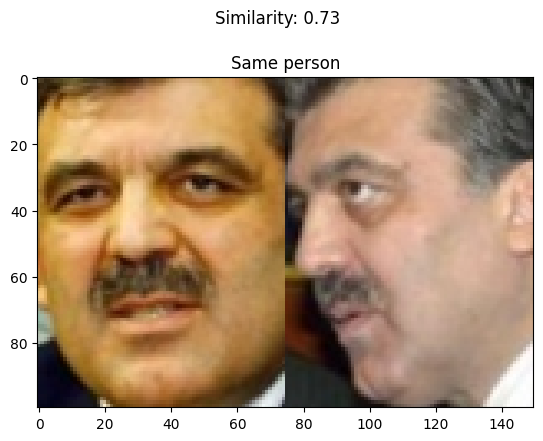

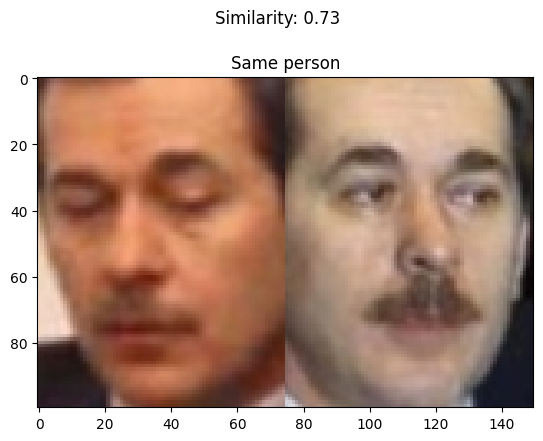

In [20]:
for i in range(3):
  visualize_pair(X_test[i][0], X_test[i][1], similarities[i], y_test[i])

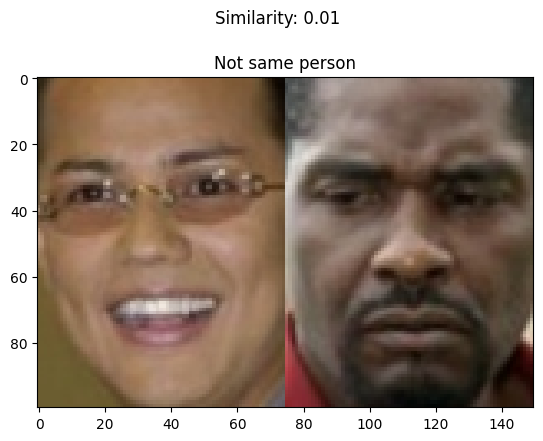

In [21]:
visualize_pair(X_test[650][0], X_test[650][1], similarities[650], y_test[650])

In [22]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml \
    -O haarcascade_frontalface_default.xml

--2024-05-05 12:48:13--  https://raw.githubusercontent.com/computationalcore/introduction-to-opencv/master/assets/haarcascade_frontalface_default.xml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 930127 (908K) [text/plain]
Saving to: ‘haarcascade_frontalface_default.xml’

haarcascade_frontal 100%[===================>] 908.33K  --.-KB/s    in 0.05s   

2024-05-05 12:48:13 (18.5 MB/s) - ‘haarcascade_frontalface_default.xml’ saved [930127/930127]



In [45]:
face_cascade = cv2.CascadeClassifier('/content/haarcascade_frontalface_default.xml')

In [62]:
duc1 = cv2.imread('/content/drive/MyDrive/Colab Notebook/DADN/data/duc/07060847-61d0-4d0f-9b01-e8449c21851f.jpg')
duc2 = cv2.imread('/content/drive/MyDrive/Colab Notebook/DADN/data/duc/46ca0876-b37b-47cf-b569-3bbc432d553e.jpg')

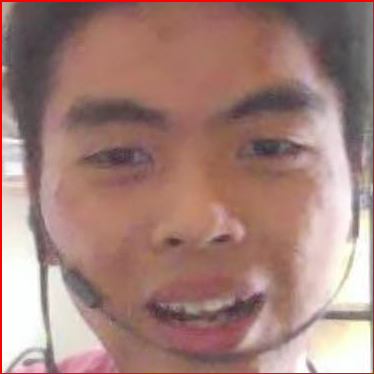

In [63]:
# Detect faces
gray1 = cv2.cvtColor(duc1, cv2.COLOR_BGR2GRAY)
faces1 = face_cascade.detectMultiScale(gray1, 1.1, 4)
faces1 = faces1[np.argmax(faces1[:, 2])]
faces1 = np.expand_dims(faces1, 0)
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces1:
    cv2.rectangle(duc1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces1 = duc1[y:y + h, x:x + w]
    cv2_imshow(faces1)

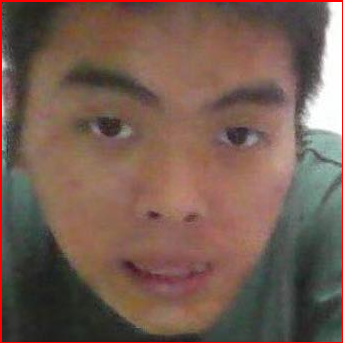

In [64]:
# Detect faces
gray2 = cv2.cvtColor(duc2, cv2.COLOR_BGR2GRAY)
faces2 = face_cascade.detectMultiScale(gray2, 1.1, 4)
faces2 = faces2[np.argmax(faces2[:, 2])]
faces2 = np.expand_dims(faces2, 0)
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces2:
    cv2.rectangle(duc2, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces2 = duc2[y:y + h, x:x + w]
    cv2_imshow(faces2)

In [65]:
duc1 = cv2.resize(faces1, (75, 100))
duc2 = cv2.resize(faces2, (75, 100))

In [66]:
cv2.imwrite('duc1.png', duc1)
cv2.imwrite('duc2.png', duc2)

True

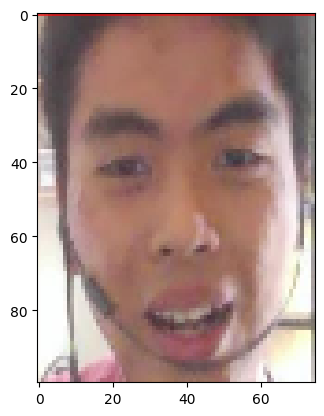

In [67]:
duc1 = plt.imread('duc1.png')
plt.imshow(duc1)

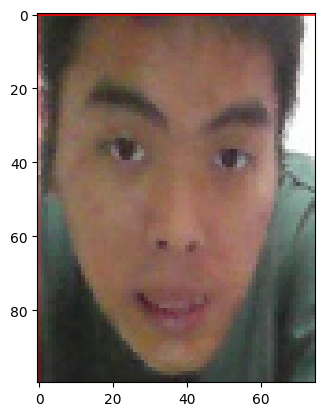

In [68]:
duc2 = plt.imread('duc2.png')
plt.imshow(duc2)

In [69]:
anchor_input = tf.keras.Input(shape=IMG_SHAPE)
anchor_embeddings = embedding_layer(anchor_input)
embedding_model = models.Model(inputs=anchor_input, outputs=anchor_embeddings)

In [70]:
embedding1 = embedding_model.predict(np.expand_dims(np.array(duc1), axis = 0))

1/1 [==============================] - 1s 873ms/step


In [71]:
embedding2 = embedding_model.predict(np.expand_dims(np.array(duc2), axis = 0))

1/1 [==============================] - 0s 68ms/step


In [72]:
embedding1[0].shape

(256,)

In [73]:
similarity = 1 - spatial.distance.cosine(embedding1[0], embedding2[0])
print(similarity)

0.478833943605423


In [75]:
khoa1 = cv2.imread('/content/drive/MyDrive/Colab Notebook/DADN/data/khoa/IMG_4147.jpg')
khoa2 = cv2.imread('/content/drive/MyDrive/Colab Notebook/DADN/data/khoa/IMG_4160.jpg')

In [76]:
# Detect faces
gray1 = cv2.cvtColor(khoa1, cv2.COLOR_BGR2GRAY)
faces1 = face_cascade.detectMultiScale(gray1, 1.1, 4)
faces1 = faces1[np.argmax(faces1[:, 2])]
faces1 = np.expand_dims(faces1, 0)
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces1:
    cv2.rectangle(khoa1, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces1 = khoa1[y:y + h, x:x + w]
    cv2_imshow(faces1)

Output hidden; open in https://colab.research.google.com to view.

In [77]:
# Detect faces
gray2 = cv2.cvtColor(khoa2, cv2.COLOR_BGR2GRAY)
faces2 = face_cascade.detectMultiScale(gray2, 1.1, 4)
faces2 = faces2[np.argmax(faces2[:, 2])]
faces2 = np.expand_dims(faces2, 0)
# Draw rectangle around the faces and crop the faces
for (x, y, w, h) in faces2:
    cv2.rectangle(khoa2, (x, y), (x+w, y+h), (0, 0, 255), 2)
    faces2 = khoa2[y:y + h, x:x + w]
    cv2_imshow(faces2)

Output hidden; open in https://colab.research.google.com to view.

In [78]:
khoa1 = cv2.resize(faces1, (75, 100))
khoa2 = cv2.resize(faces2, (75, 100))
cv2.imwrite('khoa1.png', khoa1)
cv2.imwrite('khoa2.png', khoa2)

True

In [80]:
embedding3 = embedding_model.predict(np.expand_dims(np.array(khoa1), axis = 0))
embedding4 = embedding_model.predict(np.expand_dims(np.array(khoa2), axis = 0))

1/1 [==============================] - 0s 70ms/step


In [81]:
similarity = 1 - spatial.distance.cosine(embedding3[0], embedding4[0])
print(similarity)

0.9694200754165649


In [83]:
similarity = 1 - spatial.distance.cosine(embedding3[0], embedding1[0])
print(similarity)

0.44347137212753296


In [85]:
similarity = 1 - spatial.distance.cosine(embedding1[0], embedding3[0])
print(similarity)

0.44347137212753296


In [86]:
similarity = 1 - spatial.distance.cosine(embedding1[0], embedding4[0])
print(similarity)

0.42159315943717957
